<a href="https://colab.research.google.com/github/ldejuan/covid/blob/master/descriptive_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import pandas as pd
import zipfile
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [0]:
#read zip train and test data set from zip Archive
PATH_DATA= "./drive/My Drive/covid/"
fileNameZip = 'covid19-global-forecasting-week-1.zip'
archiveName = "%s%s"%(PATH_DATA,fileNameZip)
trainName= 'train.csv'
testName = 'test.csv'
submissionNane = 'submission.csv'
if zipfile.is_zipfile(archiveName):
  with zipfile.ZipFile(archiveName) as archive:
    dfTrain = pd.read_csv(archive.open(trainName,'r')).\
      rename(columns={"Country/Region":"Country_Region",
                      "Province/State":"Province_State"})
      
    dfTest  = pd.read_csv(archive.open(testName,'r')).\
      rename(columns={"Country/Region":"Country_Region",
                      "Province/State":"Province_State"})
    dfSoubmission  = pd.read_csv(archive.open(submissionNane,'r'))
  

In [0]:
#Basic transformations
dfTrain['Date'] = pd.to_datetime(dfTrain['Date'])

In [0]:
def aggByCountry(x):
  x['Country_Fatalities'] = np.sum(x.Fatalities)
  x['Country_ConfirmedCases'] = np.sum(x.ConfirmedCases)
  return x
dfTrainAgg = dfTrain.groupby(["Country_Region","Date"]).apply(aggByCountry)

In [0]:
#Study only at country level
dfCountry = dfTrainAgg[["Country_Region","Date","Country_Fatalities","Country_ConfirmedCases"]]\
  .groupby(["Country_Region","Date"]).agg(lambda x: x[0])\
  .reset_index()\
  .rename(columns = {'Country_Fatalities' : 'Fatalities', 'Country_ConfirmedCases' : 'ConfirmedCases'})

In [6]:
# Some testing to ensure that the country_confirmedCase fatalities is well computed
dateMax=dfSelectedCountry['Date'].max()
dfSelectedCountry.query('Date == @dateMax').head()

NameError: ignored

In [0]:
#Analyze only countries with fatalities > SelectedFatalities
FatalitiesLevel = 3
def selectDeathDate(df):
  firstDate=df[df.Fatalities>=FatalitiesLevel].Date.min()
  df['firstDate'] = firstDate
  df['Fatality_Period'] = (df.Date - firstDate) / np.timedelta64(1, 'D')
  return df
dfCountryNoZero = dfCountry.groupby(["Country_Region"])\
  .apply(selectDeathDate)\
  .dropna()
dfCountryNoZero = dfCountryNoZero[dfCountryNoZero.Fatality_Period >=0]
# Calculate N_0 and Reset Fatality Rate
def rescaleFatalities(df):
  df['onset_Fatality'] = np.min(df.Fatalities)
  df['shifted_Fatalities'] = df.Fatalities - df.onset_Fatality
  return df

dfCountryNoZero = dfCountryNoZero.groupby(["Country_Region"]).apply(rescaleFatalities)


In [8]:
dfCountryNoZero.head()

,Country_Region,Date,Fatalities,ConfirmedCases,firstDate,Fatality_Period,onset_Fatality,shifted_Fatalities
166,Algeria,2020-03-14,3.0,37.0,2020-03-14,0.0,3.0,0.0
167,Algeria,2020-03-15,4.0,48.0,2020-03-14,1.0,3.0,1.0
168,Algeria,2020-03-16,4.0,54.0,2020-03-14,2.0,3.0,1.0
169,Algeria,2020-03-17,4.0,60.0,2020-03-14,3.0,3.0,1.0
170,Algeria,2020-03-18,7.0,74.0,2020-03-14,4.0,3.0,4.0


In [0]:
#Calculated the Daily Rate of Fatalities and ConfirmedCases at country level
def calculateRate(x):
  x['Fatalities_Rate'] = np.diff(x.Fatalities, prepend = np.NaN)/x.Fatalities
  x['ConfirmedCases_Rate'] = np.diff(x.ConfirmedCases, prepend = np.NaN)/x.ConfirmedCases
  return x
dfCountryRate = dfCountryNoZero.groupby(["Country_Region"])\
  .apply(calculateRate)\
  .dropna()
#Remove Fatalities = 0 
dfCountryRate = dfCountryRate.drop(dfCountryRate[dfCountryRate.Fatalities == 0].index)

In [0]:
#Add features
dfCountryRate['Fatalities_Log'] = np.log(dfCountryRate.Fatalities)
dfCountryRate['ConfirmedCases_Log'] = np.log(dfCountryRate.ConfirmedCases)
dfCountryRate['Period_2'] = dfCountryRate.Fatality_Period**2

SyntaxError: ignored

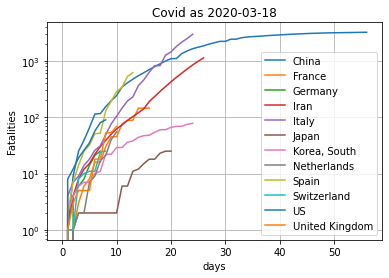

In [47]:

fig,ax = plt.subplots()
def plot_country(df):
  y=df.shifted_Fatalities
  if np.max(y) > 20 :
    x=df.Fatality_Period
    ax.plot(x,y, label = df.Country_Region.iloc[0])
    return 'success : (%s,%s)'%(np.min(x),np.min(y))
  return 'not_plot : %s'%np.min(y)

output = dfCountryNoZero.groupby(['Country_Region']).apply(plot_country)

ax.set_yscale('log')
ax.grid()
ax.set_xlabel('days')
ax.set_ylabel('Fatalities')
ax.set_title(('Covid as %s'%dfCountryNoZero.Date.iloc[-1])[:19])
ax.legend()
fig.show()

In [38]:
'%s'%dfCountryNoZero.Date.iloc[-1]

'2020-03-18 00:00:00'

In [45]:
asofDate = ('%s'%dfCountryNoZero.Date.iloc[-1])[:10]
asofDate

'2020-03-18'

In [0]:
# Submission
dfTest['ConfirmedCases'] = 10.
dfTest['Fatalities'] = 2.
dfTest[['ForecastId','ConfirmedCases','Fatalities']].to_csv('%ssoubmission.csv'%PATH_DATA, index = False)


In [32]:
dfSoubmission.head()

,ForecastId,ConfirmedCases,Fatalities
0,1,1,1
1,2,1,1
2,3,1,1
3,4,1,1
4,5,1,1
